# Use Case 7: Trans genetic effects

We will explore [trans genetic effects](https://en.wikipedia.org/wiki/Trans-acting). This occurs when a DNA mutation in one gene has an effect on a different gene. To fully understand the effect of DNA mutation, this use case will show how to find some of those downstream affected proteins using two prominent cancer genes: ARID1A and TP53.

# Part I: ARID1A

ARID1A potentially affects the transcription of many genes through its function as a chromatin remodeling protein [(Wikipedia)](https://en.wikipedia.org/wiki/ARID1A).

This gene has a well-documented set of interacting proteins, we'll examine those to find trans effects.

# Step 1: Import Libraries

Here we will import standard python libraries used to analyze and visualize data as pandas dataframes, as well as our CPTAC data.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

import cptac
import cptac.utils as ut

en = cptac.Endometrial()

Our analysis here will be done with endometrial cancer, but can also be done using any of the other cancers in the CPTAC dataset.

# Step 2: Get Interacting Proteins

Now we will get a list of the proteins that are know to interact with ARID1A directly. Our list comes from Bioplex, a process that identifies proteins in direct physical contact. The CPTAC package has a method called get_interacting_proteins_bioplex, which returns a list of proteins that interact with our gene in this way.

In [2]:
gene = "ARID1A"
omics = "proteomics"

interacting_proteins = ut.get_interacting_proteins_bioplex(gene)

print("Interacting Proteins:")
print(interacting_proteins)

Interacting Proteins:
['BCL7A', 'TEX13B', 'SMARCB1', 'WWP2', 'SMARCD1', 'SMARCE1', 'DPF2', 'BCL7C', 'SS18L2', 'DPF1', 'DPF3', 'SMARCC2', 'SS18']


# Step 3: Get Omics Data

Now we create a new dataframe containing protein measurements for ARID1A and its interacting proteins, calling en.join_omics_to_mutations. Note that if proteomics data does not identify one of the genes in your request, the join method will throw a warning and fill missing values with NaN.

In [3]:
protdf = en.join_omics_to_mutations(mutations_genes=gene, omics_df_name=omics, omics_genes=interacting_proteins)
protdf = protdf.loc[protdf['Sample_Status'] == 'Tumor']

cptac warning: The following columns were not found in the proteomics dataframe, so they were inserted into joined table, but filled with NaN: DPF1, TEX13B (<ipython-input-3-1bb85fa17bf4>, line 1)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 101 samples for the ARID1A gene (<ipython-input-3-1bb85fa17bf4>, line 1)


In [4]:
protdf.head()

Name,BCL7A_proteomics,TEX13B_proteomics,SMARCB1_proteomics,WWP2_proteomics,SMARCD1_proteomics,SMARCE1_proteomics,DPF2_proteomics,BCL7C_proteomics,SS18L2_proteomics,DPF1_proteomics,DPF3_proteomics,SMARCC2_proteomics,SS18_proteomics,ARID1A_Mutation,ARID1A_Location,ARID1A_Mutation_Status,Sample_Status
Patient_ID,,,,,,,,,,,,,,,,,
C3L-00006,0.4100,NaN,-0.111,-0.1740,-0.328,-0.3950,-0.548,-0.9180,NaN,NaN,NaN,-0.451,-0.498,[Missense_Mutation],[p.T2121P],Single_mutation,Tumor
C3L-00008,0.8880,NaN,-0.639,0.2060,-0.418,-0.5560,-0.919,-0.9410,-0.3110,NaN,NaN,-0.627,-0.162,"[Nonsense_Mutation, Frame_Shift_Del]","[p.Q403*, p.D1850Tfs*33]",Multiple_mutation,Tumor
C3L-00032,0.0927,NaN,-0.352,0.0381,-0.648,-0.5400,-0.555,-0.3880,-0.7080,NaN,NaN,-0.537,-0.448,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor
C3L-00090,0.6880,NaN,0.190,-0.2500,0.186,0.0968,0.372,-0.0328,-0.0695,NaN,NaN,-0.102,0.203,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor
C3L-00098,0.3460,NaN,-0.829,-0.3620,-0.599,0.0897,-0.642,-1.4000,0.0371,NaN,NaN,-0.432,0.298,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor


If you scroll the above table all the way to the right, you will see three columns for ARID1A mutations. These columns contain lists, as a sample may have many different mutations. The "Mutation_status" column indicates whether there is a single mutation or multiple mutations for that sample.

With what we are looking for it does not matter how many mutations a sample has, so we want to simplify the Mutation_status column to have just two values, either "Mutated" or "Wildtype." We store this in a new column "Gene Mutation Status", then remove the unnecessary columns.

In [5]:
for ind, row in protdf.iterrows():
    if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
        protdf.at[ind,'Gene Mutation Status'] = 'Mutated'
    else:
        protdf.at[ind,'Gene Mutation Status'] = 'Wildtype'

In [6]:
protdf = protdf.drop(gene+"_Mutation",axis=1)
protdf = protdf.drop(gene+"_Location",axis=1)
protdf = protdf.drop(gene+"_Mutation_Status", axis=1)
protdf = protdf.drop("Sample_Status",axis=1)

# Step 4: Do T-tests

The column names now represent the interacting proteins, so we can create a list in order to run our t-tests for each protein individually.

In [7]:
col_list = list(protdf.columns)
col_list.remove('Gene Mutation Status')

In [8]:
print(col_list)

['BCL7A_proteomics', 'TEX13B_proteomics', 'SMARCB1_proteomics', 'WWP2_proteomics', 'SMARCD1_proteomics', 'SMARCE1_proteomics', 'DPF2_proteomics', 'BCL7C_proteomics', 'SS18L2_proteomics', 'DPF1_proteomics', 'DPF3_proteomics', 'SMARCC2_proteomics', 'SS18_proteomics']


Now we call wrap_ttest, which is an accessory function in cptac.utils. It expects one column with a binary variable (this is why we created the 'Gene Mutation Status' column earlier), and all other data as numeric. It will then run ttests on each column to determine if there is a statistically significant difference between the binary values. For us, it will identify if there are significantly different protein abundances between wildtype and mutated samples.

In [9]:
print("Doing t-test comparisons\n")
wrap_results = ut.wrap_ttest(protdf, 'Gene Mutation Status', col_list)
#This gives us back a dataframe with significant comparisons

if wrap_results is not None:
        print(wrap_results)
        print("\n\n")
else:
    print("No significant comparisons found")

Doing t-test comparisons

           Comparison   P_Value
0     DPF2_proteomics  0.000002
1  SMARCB1_proteomics  0.000689
2  SMARCC2_proteomics  0.000827
3  SMARCE1_proteomics  0.001498
4  SMARCD1_proteomics  0.001745
5    BCL7C_proteomics  0.004380





Our t-test returned six proteins whose levels were significantly changed by a mutation in ARID1A. We will look at DPF2 and plot the data with Seaborn to show exactly how its levels change with our gene's mutation.

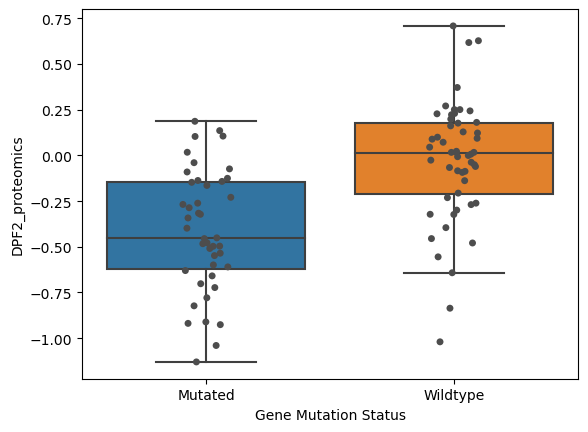

In [10]:
sns.boxplot(data = protdf, x = 'Gene Mutation Status', y = 'DPF2_proteomics', showfliers = False)
sns.stripplot(data = protdf, x = 'Gene Mutation Status', y = 'DPF2_proteomics', jitter = True, dodge = True, color = '.3')
plt.show()

From this boxplot, we can see that there is a significant decrease in DPF2 levels with a mutation in ARID1A.

# Part II: Example with TP53

We will now look at TP53: a tumor suppressing gene that is very important in helping prevent mutation, as well as repairing damaged DNA in cells [(Wikipedia)](https://en.wikipedia.org/wiki/P53).

We will use the same steps as above, this time without separated code blocks. Because we are not sure which proteins might be affected, we will look for trans effects in all the proteomics data instead of just the interacting proteins from bioplex. Due to the high number of comparisons, this will take a little bit of time. In the end, we will have a list of genes affected by TP53.

In [11]:
gene = "TP53"
print("\nGene: ", gene)

# Step 1: Create dataframe in order to do comparisons with wrap_ttest
# Note that here we do not pass any values for 'omics_genes', so it will use all available genes
protdf = en.join_omics_to_mutations(mutations_genes=[gene], omics_df_name=omics)
protdf = protdf.loc[protdf['Sample_Status'] == 'Tumor']

for ind, row in protdf.iterrows():
    if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
        protdf.at[ind,'ARID1A Mutation Status'] = 'Mutated'
    else:
        protdf.at[ind,'ARID1A Mutation Status'] = 'Wildtype'

        
# Step 2: Format the dataframe to set it up properly for our t-test
protdf = protdf.drop(gene+"_Mutation",axis=1)
protdf = protdf.drop(gene+"_Location",axis=1)
protdf = protdf.drop(gene+"_Mutation_Status", axis=1)
protdf = protdf.drop("Sample_Status",axis=1)


#Step 3: Make list of columns to be compared using t-tests
col_list = list(protdf.columns)
col_list.remove('ARID1A Mutation Status')

    
#Step 4: Call wrap_ttest, pass in formatted dataframe, print results
print("Doing t-test comparisons\n")
wrap_results = ut.wrap_ttest(protdf, 'ARID1A Mutation Status', col_list)

if wrap_results is not None:
        print(wrap_results)
        print("\n\n")


Gene:  TP53


cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 123 samples for the TP53 gene (<ipython-input-11-1c38b77911cb>, line 6)


Doing t-test comparisons

              Comparison       P_Value
0      MTHFD2_proteomics  9.877237e-08
1    SLC4A1AP_proteomics  6.355764e-07
2        XPO5_proteomics  1.647660e-06
3       TRMT6_proteomics  1.913196e-06
4       STAT2_proteomics  2.041726e-06
..                   ...           ...
131     PRPF6_proteomics  4.582856e-02
132     KDM2A_proteomics  4.690350e-02
133      PBLD_proteomics  4.712490e-02
134     USP14_proteomics  4.785630e-02
135    STARD7_proteomics  4.907818e-02

[136 rows x 2 columns]





Each of the proteins shown can be individually analyzed in the same manner that we showed above. It's worth noting that with some genes this list might be relatively small because our wrap_ttest does Bonferroni correction, so the cutoff for "significance" is very strict. For further ideas about how to analyze larger lists of genes, refer to usecase 5.